# Optic Flow Experiment Demo
Inspired by: A Robust Road Vanishing Point Detection Adapted to the
Real-World Driving Scenes

Based on the:
1. analysis
2. stable motion detection
3. stationary point-based motion vector selection
4. angle-based RANSAC
(RANdom SAmple Consensus) voting

In [1]:
RUN_WITH_YOLO_SEG = True
# file = "10 sec video 1 mototrway crash h.264.mp4"
# file = "250222_080729_006_FH.MP4"
# file = "test_20s_video.MP4"
file = "test_15s_video.MP4"

START_FRAME = 0
RUN_UP = False
RUN_UP_FRAMES = 40
END_FRAME = None
OUTPUT_FOLDER = None

STANDARD_RESOLUTION = (2560, 1440)
Main_Cam_Calibration_path = "main_cam_calibration.npz"

In [2]:
# !pip install opencv-python numpy matplotlib ultralytics --quiet

In [3]:
import cv2
import os
import copy
import argparse
import numpy as np
from matplotlib import pyplot as plt

In [4]:
parser = argparse.ArgumentParser(
    description="Process input and output paths for video processing."
)

parser.add_argument(
    "-i", "--input", 
    help="Path to the input video file.", 
    required=False
)

parser.add_argument(
    "-o", "--output", 
    help="Path to the output folder.", 
    required=False
)

parser.add_argument(
    "-s", "--start_frame", 
    help="Starting frame number for processing.",
    required=False
)

parser.add_argument(
    "-e", "--end_frame", 
    help="Ending frame number for processing.",
    required=False
)

parser.add_argument(
    "-r", "--run_up", 
    help="Run up the video processing.",
    action="store_true",
    required=False
)


parser.add_argument(
    "--f", "--kernel_launcher", 
    help="Path to the kernel launcher file.",
    required=False
)


args = parser.parse_args()

if args.input and args.output:
    args = parser.parse_args()
    
    file = args.input
    OUTPUT_FOLDER = args.output
    if args.start_frame:
        START_FRAME = int(args.start_frame)
    if args.end_frame:
        END_FRAME = int(args.end_frame)

    if args.run_up:
        # add run up frames to the start frame
        RUN_UP = True
        START_FRAME = START_FRAME - RUN_UP_FRAMES
    print("System arguments detected:", args)

In [5]:
# check if cli call
if OUTPUT_FOLDER:
    if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)
else:
    OUTPUT_FOLDER = "temp/" + file.split(".")[0]
    if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)
cap = cv2.VideoCapture(file)
total_number_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
RESOLUTION = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

if RESOLUTION != STANDARD_RESOLUTION:
    print(f"Warning: Video resolution is {RESOLUTION}, expected {STANDARD_RESOLUTION}.")
    print("This may cause issues with the processing.")
else:
    print(f"Video resolution is {RESOLUTION}, as expected.")

# START_FRAME = 490

# END_FRAME = 550 # Manual test override

print(f'Processing file: {file}')
print(f'Total number of frames: {total_number_of_frames}')
print(f'Output folder: {OUTPUT_FOLDER}')
print(f'Start frame: {START_FRAME}')
print(f'End frame: {END_FRAME}')

# frame range check
if START_FRAME < 0:
    raise ValueError("Start frame cannot be negative.")
if END_FRAME and END_FRAME > total_number_of_frames:
    raise ValueError("End frame cannot be greater than total number of frames.")
if END_FRAME and END_FRAME < START_FRAME:
    raise ValueError("End frame cannot be less than start frame.")
if END_FRAME is None:
    END_FRAME = total_number_of_frames

total_number_of_frames = END_FRAME - START_FRAME
print(f'Total number of frames to process: {total_number_of_frames}')

Video resolution is (2560, 1440), as expected.
Processing file: test_15s_video.MP4
Total number of frames: 421
Output folder: temp/test_15s_video
Start frame: 0
End frame: None
Total number of frames to process: 421


### Frame handling

In [6]:
MTX = None
DIST = None
NEW_CAMERA_MTX = None
ROI = None

if os.path.exists(Main_Cam_Calibration_path):
    data = np.load(Main_Cam_Calibration_path)
    MTX = data['mtx']
    DIST = data['dist']

    # INITIAL FRAME
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, img = cap.read()
    if not ret:
        raise ValueError("Could not read the first frame of the video.")
    h, w = img.shape[:2]
    NEW_CAMERA_MTX, ROI = cv2.getOptimalNewCameraMatrix(MTX, DIST, (w, h), 1, (w, h))

    print("Camera calibration loaded")

def undistort(img, newcameramtx=NEW_CAMERA_MTX, mtx=MTX, dist=DIST, roi=ROI):
    """
    Undistort the image using the camera calibration parameters.
    """
    if mtx is None or dist is None:
        return img
    else:
        # print("Undistorting image")
        # undistort
        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
        x, y, w, h = roi
        dst = dst[y:y+h, x:x+w]
        dst = cv2.resize(dst, (img.shape[1], img.shape[0]))
        return dst


Camera calibration loaded


In [7]:
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return gray

def get_frame(cap, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = cap.read()
    if not success:
        raise ValueError(f"Failed to read frame at position {frame_number}")
    
    # Undistort the frame
    if file.endswith("FH.MP4"):
        frame = undistort(frame)
    
    # Resize frame to standard resolution
    if RESOLUTION != STANDARD_RESOLUTION:
        frame = cv2.resize(frame, STANDARD_RESOLUTION)
    
    # frame = cv2.resize(frame, (640, 480))
    processed_frame = preprocess_frame(frame)
    return frame, processed_frame

# Video Builder

In [8]:
class VideoBuilder:
    def __init__(self, filename, fps):
        self.fps = fps
        self.output_file = filename
        self.recorder = None

    def add_frame(self, frame):
        if self.recorder is None:
            self.recorder = cv2.VideoWriter(self.output_file, cv2.VideoWriter_fourcc(*'XVID'), self.fps, (frame.shape[1], frame.shape[0]))

        self.recorder.write(frame)

    def stop_recording(self):
        if self.recorder is not None:
            self.recorder.release()
            self.recorder = None


# Yolo Segmentation Mask

In [9]:
from ultralytics import YOLO

# segmentation model
model = YOLO("yolo11m-seg.pt")  # load a pretrained model (recommended for inference)

def get_vehicle_mask(_frame):
    # run the model on the frame
    results = model([_frame], verbose=False)

    # get the first result (the only one in this case)
    if len(results) == 0:
        print("No results found.")
        return np.zeros((_frame.shape[0], _frame.shape[1]), dtype=np.uint8)
    
    result = results[0]
    # result.save(filename="result.jpg")

    if result.masks is None or result.boxes is None:
        # print("No masks or boxes found.")
        return np.zeros((_frame.shape[0], _frame.shape[1]), dtype=np.uint8)
    
    masks = result.masks.data.cpu().numpy()  
    class_ids = result.boxes.cls.cpu().numpy().astype(int)

    vehicle_classes = {"car", "truck", "bus", "motorcycle", "bicycle"}
    _mask = np.zeros((_frame.shape[0], _frame.shape[1]), dtype=np.uint8)

    for i, class_id in enumerate(class_ids):
        class_name = model.names[class_id]
        if class_name in vehicle_classes:
            resized_mask = cv2.resize(
                masks[i].astype(np.uint8),
                (_frame.shape[1], _frame.shape[0]),  # (width, height)
                interpolation=cv2.INTER_NEAREST
            )

            # ignore if mask uses over 50% of the image (when it selects the host car)
            if np.sum(resized_mask.astype(np.uint8)) / (resized_mask.shape[0] * resized_mask.shape[1]) > 0.5:
                continue

            _mask = np.logical_or(_mask, resized_mask).astype(np.uint8)

    vehicle_mask = _mask.astype(np.uint8)  # 0 or 1

    return vehicle_mask


# frame = get_frame(cap, 0)[0]

# # get the vehicle mask
# vehicle_seg_mask = get_vehicle_mask(frame)

# plt.imshow(vehicle_seg_mask, cmap='gray')

In [10]:
def is_point_on_vehicle(point, mask):
    x, y = int(point[0]), int(point[1])
    if x < 0 or y < 0 or x >= mask.shape[1] or y >= mask.shape[0]:
        return False
    return mask[y, x] == 1

# Motion Vector Detection

initialise motion detection parameters

In [11]:
# params for Shi-Tomasi corner detection
feature_params = dict( maxCorners = 2, # 50 for non grid based
                       qualityLevel = 0.3,
                       minDistance = 30,
                       blockSize = 7,)

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# minimum displacement
MINIMUM_TRACKED_POINTS = 300
MINIMUM_DISPLACEMENT = 1
MAXIMUM_TRAJECTORY_LENGTH = 25

# R-VP parameters
THRESHOLD_REMOVE_SHORT_TRAJECTORIES = 12

In [12]:
THRESHOLD_REMOVE_SHORT_TRAJECTORIES

12

corner detection mask to select new points from a distance (Region of interest)

(np.float64(-0.5), np.float64(2559.5), np.float64(1439.5), np.float64(-0.5))

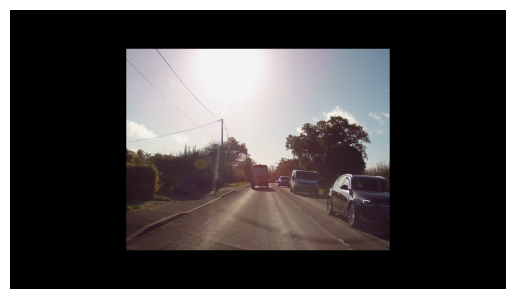

In [13]:
frame, _ = get_frame(cap, 0)

frame_height, frame_width = frame.shape[:2]
mask = np.ones((frame_height, frame_width), dtype=np.uint8)

# apply mask to select new points from a distance (Region of interest)
mask[-200:] = 0
mask[:200] = 0
mask[:, :600] = 0
mask[:, -600:] = 0

masked_bgr = cv2.bitwise_and(frame, frame, mask=mask)
masked_bgr = cv2.cvtColor(masked_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(masked_bgr)
plt.axis('off')

### Corner Feature Detection
Detect corners using Shi-Tomasi corner detection algorithm.

In [14]:
# all_corners = []

# corner_cache = {} # cache to optimise when tweaking parameters

# def get_points_of_frame(frame_number):
#     if frame_number in corner_cache:
#         return corner_cache.get(frame_number)
    
#     _, frame = get_frame(cap, frame_number) # using processed frame, not original

#     # shi-tomasi corner detection
#     corners = cv2.goodFeaturesToTrack(frame, mask = mask, **feature_params)

#     if corners is None:
#         print(f"No corners found in frame {frame_number}.")
#         return None

#     corner_cache[frame_number] = corners
#     return corners

def split_into_grid(frame, grid_size):
    height, width = frame.shape
    grid_height, grid_width = grid_size
    grid_height = height // grid_height
    grid_width = width // grid_width

    grid = []
    for i in range(0, height, grid_height):
        for j in range(0, width, grid_width):
            grid.append(
                [i,j,frame[i:i+grid_height, j:j+grid_width]]
            )

    return grid

# def get_points_of_frame(frame_number):
#     _, frame = get_frame(cap, frame_number) # using processed frame, not original
#     frame = cv2.bitwise_and(frame, frame, mask=mask)

#     grid = split_into_grid(frame, (4, 4))

#     corner_list = []

#     for g in grid:
#         # shi-tomasi corner detection
#         new_corners = cv2.goodFeaturesToTrack(g[2], **feature_params)
#         if new_corners is None:
#             continue
        
#         for corner in new_corners:
#             corner[0][0] += g[1]
#             corner[0][1] += g[0]
#             corner_list.append(corner[0])

#     corner_list = np.array(corner_list, dtype=np.float32)
#     corner_list = corner_list.reshape(-1, 1, 2)

#     return corner_list

def get_points_of_frame(frame_number):
    # 1) grab the GREY frame
    _, gray = get_frame(cap, frame_number)

    # 2) split that full grey image into your 4×4 grid
    grid = split_into_grid(gray, (20, 20))

    all_pts = []
    for y0, x0, cell in grid:
        # 3) detect up to  maxCorners points _within each cell_
        pts = cv2.goodFeaturesToTrack(cell,
                                      mask=None,  # no mask here!
                                      **feature_params)
        if pts is None: 
            continue

        # 4) re-offset the cell’s (0,0) back to full-frame coords
        for p in pts:
            p[0][0] += x0
            p[0][1] += y0
            all_pts.append(p[0])

    # apply mask of roi
    all_pts = np.array(all_pts, dtype=np.float32)
    all_pts = all_pts.reshape(-1, 2)
    all_pts = [p for p in all_pts if is_point_on_vehicle(p, mask)]
    all_pts = np.array(all_pts, dtype=np.float32)
    all_pts = all_pts.reshape(-1, 1, 2)




    return np.array(all_pts, dtype=np.float32).reshape(-1,1,2)


Example frame 0 with 258 corners


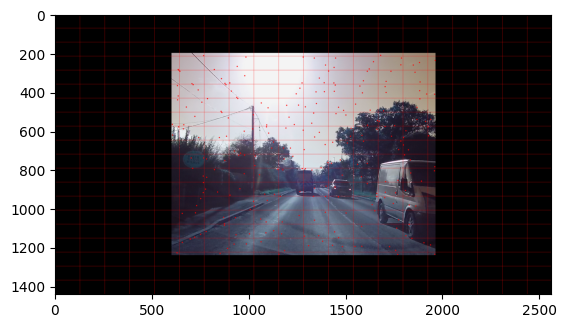

In [15]:
frame = get_frame(cap, 20)[0]
corners = get_points_of_frame(0)

print(f'Example frame {0} with {len(corners)} corners')

frame = cv2.bitwise_and(frame, frame, mask=mask)

for corner in corners:
    x, y = corner[0]
    cv2.circle(frame, (int(x), int(y)), 3, 255, -1)

# draw (8,8) grid
for i in range(0, frame.shape[0], frame.shape[0]//20):
    cv2.line(frame, (0, i), (frame.shape[1], i), 255, 1)

for i in range(0, frame.shape[1], frame.shape[1]//20):
    cv2.line(frame, (i, 0), (i, frame.shape[0]), 255, 1)
    
plt.imshow(frame)

### Feature Tracking using Lucas-Kanade Optical Flow

#### Output video of the motion vectors

In [16]:
# random colours to label different lines
color = np.random.randint(0, 255, (400000, 3))

def get_frame_with_trajectories(frame_number, trajectories):
    original_frame, _ = get_frame(cap, frame_number)

    original_frame = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)

    if RUN_WITH_YOLO_SEG:
        # Draw the mask on the original frame with 50% opacity
        vehicle_mask = get_vehicle_mask(original_frame)  # values 0 or 1
        
        colored_mask = np.zeros_like(original_frame)
        colored_mask[vehicle_mask == 1] = (0, 0, 255)  
        original_frame = cv2.addWeighted(original_frame, 1.0, colored_mask, 0.5, 0)
    
    # Draw the full trajectories
    for start_position, points in trajectories.items():
        color_idx = hash(start_position) % len(color) # Get a consistent color based on start position
        for j in range(1, len(points)): # Draw a line between all consecutive points
            a, b = points[j]
            c, d = points[j - 1]
            original_frame = cv2.line(original_frame, (int(a), int(b)), (int(c), int(d)), color[color_idx].tolist(), 2)

    # Draw current points as circles
    for start_position, points in trajectories.items():
        color_idx = hash(start_position) % len(color) # Get a consistent color based on start position
        a, b = points[-1] # draw the last point
        original_frame = cv2.circle(original_frame, (int(a), int(b)), 5, color[color_idx].tolist(), -1)

    return original_frame


# create frames with trajectories and save them to a video
def output_video_of_trajectories(frame_trajectories, _start_frame, _end_frame, filename):
    video = VideoBuilder(filename, 30)
    for i in range(_start_frame, _end_frame):
        frame_number = i
        trajectories = frame_trajectories[i - _start_frame]
        frame = get_frame_with_trajectories(frame_number, trajectories)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video.add_frame(frame)
    video.stop_recording()

#### Remove stationary points
Filter and remove points that are not moving more than Min_displacement

In [17]:
def filter_for_minimum_displacement(good_old, good_new):
    """
    Filter out points that have not moved significantly.

    Args:
        good_old: old features from good matches
        good_new: new features from good matches

    Returns:
        list: filtered good_old and good_new points
    """
    new_good_old = []
    new_good_new = []
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        new_x, new_y = new.ravel()
        old_x, old_y = old.ravel()
        if abs(new_x - old_x) > MINIMUM_DISPLACEMENT or abs(new_y - old_y) > MINIMUM_DISPLACEMENT:
            new_good_old.append(old)
            new_good_new.append(new)
    return np.array(new_good_old), np.array(new_good_new)

#### Clip max trajectory length
Hard limit length of a tracked point

In [18]:
def clip_max_trajectory(trajectory_list):
    """
    Clip the trajectory list to the maximum length.

    Args:
        trajectory_list (list): list of trajectory records

    Returns:
        list: clipped trajectory list
    """
    return trajectory_list[-MAXIMUM_TRAJECTORY_LENGTH:]

Check if trajectories moving towards edge of the image

In [19]:
def remove_trajectories_not_diverging_from_center_x_axis(trajectories, center_x):
    """
    Remove trajectories that are not diverging from the center.

    Args:
        trajectories (dict): dictionary of trajectories

    Returns:
        dict: filtered trajectories
    """
    filtered_trajectories = {}
    for start_position, points in trajectories.items():
        # print(f"Trajectory {start_position}: {points}")
        if len(points) > 1:
            # Calculate the distance from the first point to the last point
            # print(f"Trajectory {start_position}: {points}")

            if len(points) >= 5:
                x_diff = points[-1][0] - points[-5][0]
                y_diff = points[-1][1] - points[-5][1]

                if len(points) > 10:
                    x_diff = points[-1][0] - points[-10][0]
                    y_diff = points[-1][1] - points[-10][1]

                    if np.sqrt(x_diff**2 + y_diff**2) < (MINIMUM_DISPLACEMENT*7):
                    # print(f"Trajectory {start_position} is not diverging from center x axis.")
                        continue

                # check if in last 200 pixels from edge
                if points[-1][0] < 300 or points[-1][0] > (frame_width - 300):
                    continue
                if points[-1][1] < 200 or points[-1][1] > (frame_height - 200):
                    continue

                # if points[-1][0] < center_x:
                #     if x_diff < 0:
                #         continue
                # else:
                #     if x_diff > 0:
                #         continue

            filtered_trajectories[start_position] = points
    return filtered_trajectories

#### Perform tracking
- Points over many consecutive frames are considered stable motion vectors

In [20]:
def get_all_frame_trajectories(start_frame=0, end_frame=None):
    all_frame_trajectories = [] # store all trajectories for each frame

    # initial frame and starting points
    p0 = get_points_of_frame(start_frame)
    _, last_frame = get_frame(cap, start_frame)

    # Init tracked points
    trajectories = {tuple(p.ravel()): [p.ravel()] for p in p0}

    # Store initial trajectories
    all_frame_trajectories.append(copy.deepcopy(trajectories))

    if end_frame is None:
        end_frame = total_number_of_frames

    # for each frame at an increment of 1
    for i in range(start_frame + 1, end_frame):
        colour_frame , frame_gray = get_frame(cap, i)
        
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(last_frame, frame_gray, p0, None, **lk_params)

        # Select good points
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]

        # Filter out points that have not moved above a given threshold
        good_old, good_new = filter_for_minimum_displacement(good_old, good_new)

        # get a tracked point using the last tracked position as the key
        new_trajectories = {}

        for new, old in zip(good_new, good_old):
            start_position = tuple(old.ravel())  # Use the original position as the key
            next_iterations_start_position = tuple(new.ravel())  # Use the new position as the key for the next iteration

            # Check if the new point is on a vehicle in the mask
            if start_position in trajectories:
                # Update tracked points with new position
                trajectories[start_position].append(tuple(new.ravel()))
                # create a new set of trajectories with the new position as the key
                new_trajectories[next_iterations_start_position] = clip_max_trajectory(trajectories[start_position])

        # Replace old trajectories with updated ones that exclude lost points
        trajectories = new_trajectories

        # remove trajectories that are not diverging from the center
        center_x = frame_gray.shape[1] // 2
        trajectories = remove_trajectories_not_diverging_from_center_x_axis(trajectories, center_x)

        if RUN_WITH_YOLO_SEG:
            vehicle_mask = get_vehicle_mask(colour_frame)
            filtered = {}
            for start, pts in trajectories.items():
                last_pt = pts[-1]
                if not is_point_on_vehicle(last_pt, vehicle_mask):
                    filtered[start] = pts
            trajectories = filtered


        # make a record of the trajectories at frame i
        all_frame_trajectories.append(copy.deepcopy(trajectories))

        # prepare for next iteration
        last_frame = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

        # keep adding points once fall below a minimum threshold
        if len(p0) < MINIMUM_TRACKED_POINTS:
            new_points = get_points_of_frame(i)
            p0 = np.concatenate((p0, new_points), axis=0)
            # add new points to next tracked trajectories
            for new_p in new_points:
                start_position = tuple(new_p.ravel())
                if start_position not in trajectories:
                    trajectories[start_position] = [tuple(new_p.ravel())]
    
    return all_frame_trajectories

print("Tracking trajectories...")
all_frame_trajectories = get_all_frame_trajectories(START_FRAME, END_FRAME)

Tracking trajectories...


#### Display tracked points counts by frame

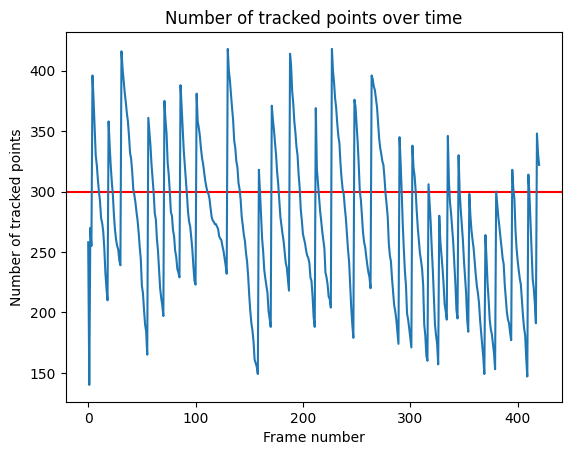

In [21]:
x = np.arange(0, total_number_of_frames)
y = [len(frame_trajectories) for frame_trajectories in all_frame_trajectories]

plt.axhline(y=MINIMUM_TRACKED_POINTS, color='r', linestyle='-')
plt.title('Number of tracked points over time')
plt.xlabel('Frame number')
plt.ylabel('Number of tracked points')
plt.plot(x, y)

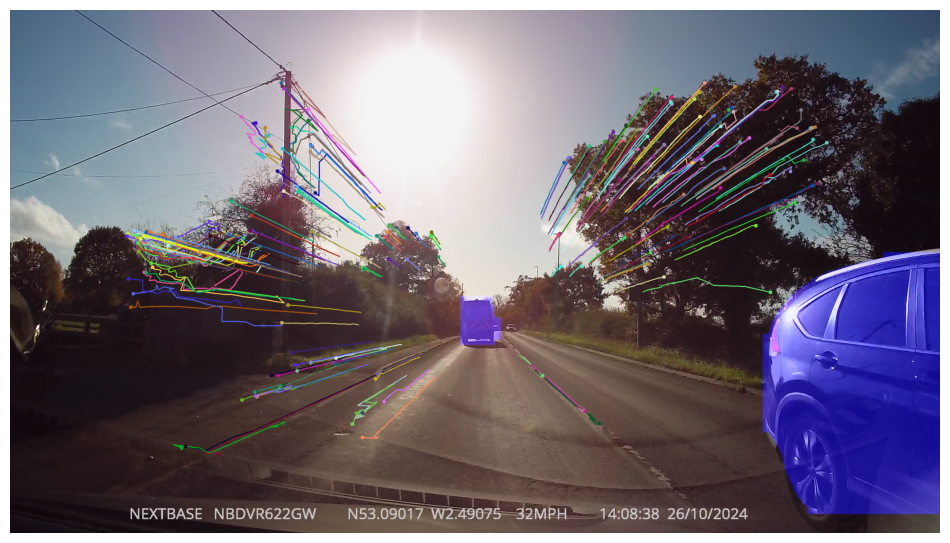

In [22]:
example_frame = 280

if END_FRAME is not None:
    example_frame = START_FRAME + 50

# filter related frame for short trajectories
trajectories = all_frame_trajectories[example_frame-START_FRAME]
ignore_short_history_trajectories = {start_position: points for start_position, points in trajectories.items() if len(points) > THRESHOLD_REMOVE_SHORT_TRAJECTORIES}

# display frame with trajectories
frame = get_frame_with_trajectories(example_frame, ignore_short_history_trajectories)
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(frame)

# Choosing stationary object motion vectors

Remove vector paths with low momentum

# R-VP Voting
Using RANSAC to find the best vanishing point

#### RANSAC voting

In [23]:
import numpy as np

def find_vanishing_point(line_segments, iterations=500, threshold=10,  inlier_ratio=0.6):
    best_vanishing_point = None
    max_inliers = 0
    total_segments = len(line_segments)
    
    # pre-solve slopes and intercepts
    slopes = []
    intercepts = []
    for (start, end) in line_segments:
        x1, y1 = start
        x2, y2 = end
        if x2 != x1:  # Non-vertical line
            m = (y2 - y1) / (x2 - x1)
            c = y1 - m * x1
        else:  # Vertical line case, set slope to None
            m, c = None, x1
        slopes.append(m)
        intercepts.append(c)
    
    slopes = np.array(slopes)
    intercepts = np.array(intercepts)

    if total_segments < 2:
        print("Not enough line segments to find a vanishing point.")
        return None, 0
    
    for _ in range(iterations):
        # Randomly select two line segments
        idx1, idx2 = np.random.choice(total_segments, 2, replace=False)
        
        m1, c1 = slopes[idx1], intercepts[idx1]
        m2, c2 = slopes[idx2], intercepts[idx2]
        
        # Skip if parallel or identical (no unique intersection)
        if m1 == m2:
            continue
        
        # Calculate intersection point
        if m1 is not None and m2 is not None:
            # Both lines are non-vertical
            x_intersect = (c2 - c1) / (m1 - m2)
            y_intersect = m1 * x_intersect + c1
        elif m1 is None:  # Line 1 is vertical
            x_intersect = c1
            y_intersect = m2 * x_intersect + c2
        elif m2 is None:  # Line 2 is vertical
            x_intersect = c2
            y_intersect = m1 * x_intersect + c1
        
        intersection_point = np.array([x_intersect, y_intersect])
        
        # Calculate distances for all line segments to this intersection point
        distances = []
        for i, (m, c) in enumerate(zip(slopes, intercepts)):
            if m is not None:
                # Non-vertical line: calculate perpendicular distance
                y_hat = m * x_intersect + c
                distance = abs(y_hat - y_intersect)
            else:
                # Vertical line: distance is horizontal distance
                distance = abs(x_intersect - c)
            distances.append(distance)
        
        distances = np.array(distances)
        inliers = distances < threshold
        num_inliers = np.sum(inliers)
        
        # Update best vanishing point if this one has more inliers
        if num_inliers > max_inliers:
            best_vanishing_point = intersection_point
            max_inliers = num_inliers
            
            # Early stopping if enough inliers found
            if max_inliers / total_segments >= inlier_ratio:
                break
    
    return best_vanishing_point, max_inliers

In [24]:
ransac_vectors = []

for start_position, points in ignore_short_history_trajectories.items():
    for i in range(1, len(points)):
        # Store both start and end points of each vector
        start_point = points[i - 1]
        end_point = points[i]
        ransac_vectors.append([start_point, end_point])

ransac_vectors = np.array(ransac_vectors)

vanishing_point, inliers_count = find_vanishing_point(ransac_vectors)

if vanishing_point is None:
    print("No vanishing point found.")
else:
    print("Vanishing point found at:", vanishing_point)
    print("Number of inliers:", inliers_count)

Vanishing point found at: [     1323.8      872.66]
Number of inliers: 1125


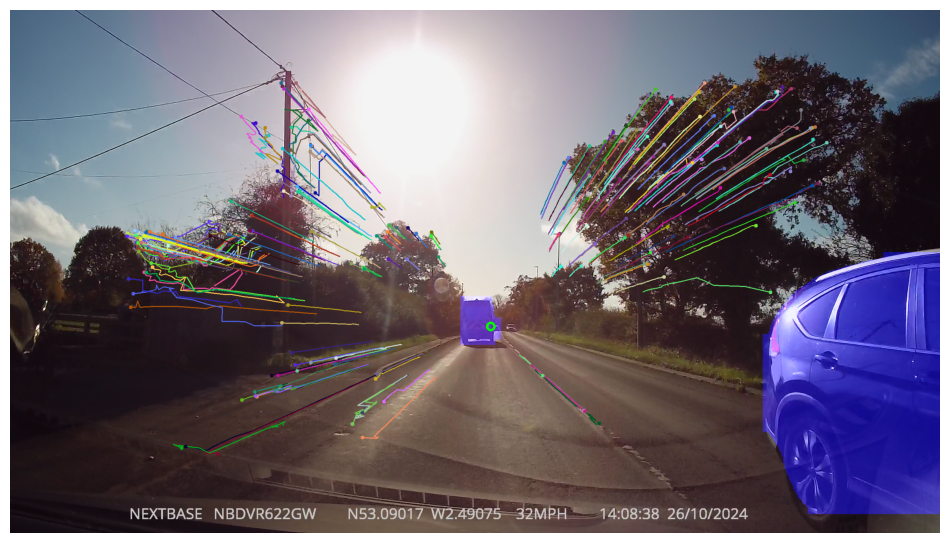

In [25]:
frame = get_frame_with_trajectories(example_frame, ignore_short_history_trajectories)

# Draw vp
if vanishing_point is not None:
    frame = cv2.circle(frame, tuple(vanishing_point.astype(int)), 10, (0, 255, 0), 6)

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(frame)

#### Find R-VP using RANSAC on all frames
Run R-VP voting on all frames and add the best vanishing point to all_vp

In [26]:
print ("Processing all frames for vanishing points")
all_vp = []

for i in range(total_number_of_frames):
    trajectories = all_frame_trajectories[i]
    ignore_short_history_trajectories = {start_position: points for start_position, points in trajectories.items() if len(points) > THRESHOLD_REMOVE_SHORT_TRAJECTORIES}
    ransac_vectors = []

    for start_position, points in ignore_short_history_trajectories.items():
        for i in range(1, len(points)):
            start_point = points[i - 1]
            end_point = points[i]
            ransac_vectors.append([start_point, end_point])

    ransac_vectors = np.array(ransac_vectors)

    if len(ransac_vectors) < 2:
        all_vp.append(np.array([0, 0]))
        continue
    vanishing_point, inliers_count = find_vanishing_point(ransac_vectors)
    if vanishing_point is None:
        print("No vanishing point found.")
        all_vp.append(np.array([0, 0]))
    else:
        all_vp.append(vanishing_point)

all_vp = np.array(all_vp)

Processing all frames for vanishing points


In [27]:
def output_video_of_R_VP(VP, trajectories, _start_frame, _end_frame, filename , average_vp=None, median_vp=None):
    video = VideoBuilder(filename, 30)
    print(f"Outputting video to {filename} from {_start_frame} to {_end_frame}")
    for i in range(_end_frame - _start_frame):
        frame_number = _start_frame + i
        # print(f"Processing frame {frame_number}")
        vanishing_point = VP[i]
        frame = get_frame_with_trajectories(frame_number, trajectories[i])
        if vanishing_point is not None:
            frame = cv2.circle(frame, tuple(vanishing_point.astype(int)), 10, (0, 255, 0), 5)

        if average_vp is not None:
            frame = cv2.circle(frame, tuple(average_vp.astype(int)), 10, (255, 0, 0), 5)

        if median_vp is not None:
            frame = cv2.circle(frame, tuple(median_vp.astype(int)), 10, (0, 0, 255), 5)
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video.add_frame(frame)
    video.stop_recording()

# Store Fixed Road Vanishing Point for Pipeline

In [28]:
# remove run up frames
print("Outputting video of R-VP and average_vp")
START_FRAME_ADJUSTED = START_FRAME + RUN_UP_FRAMES

Outputting video of R-VP and average_vp


In [29]:
def get_average_vanishing_point(vp_list):
    """
    Calculate the average vanishing point from a list of vanishing points.

    Args:
        vp_list (list): list of vanishing points

    Returns:
        np.array: average vanishing point
    """

    vp_without_zeros = [vp for vp in vp_list if not np.array_equal(vp, np.array([0, 0]))]

    if len(vp_without_zeros) == 0:
        return None
    return np.mean(vp_without_zeros, axis=0)

def get_median_vanishing_point(vp_list):
    """
    Calculate the average vanishing point from a list of vanishing points.

    Args:
        vp_list (list): list of vanishing points

    Returns:
        np.array: average vanishing point
    """

    vp_without_zeros = [vp for vp in vp_list if not np.array_equal(vp, np.array([0, 0]))]

    if len(vp_without_zeros) == 0:
        return None
    return np.median(vp_without_zeros, axis=0)


vp_after_run_up_removal = all_vp[RUN_UP_FRAMES:]
trajectories_after_run_up_removal = all_frame_trajectories[RUN_UP_FRAMES:]

average_vp = get_average_vanishing_point(vp_after_run_up_removal)
median_vp = get_median_vanishing_point(vp_after_run_up_removal)

original_average_vp = copy.deepcopy(average_vp)
original_median_vp = copy.deepcopy(median_vp)

if STANDARD_RESOLUTION != RESOLUTION:
    print(f"Average vanishing point was: {average_vp}")
    average_vp_x = average_vp[0] * (RESOLUTION[0] / STANDARD_RESOLUTION[0])
    average_vp_y = average_vp[1] * (RESOLUTION[1] / STANDARD_RESOLUTION[1])
    average_vp = np.array([average_vp_x, average_vp_y])
    print("Average vanishing point after scaling:", average_vp)
    median_vp_x = median_vp[0] * (RESOLUTION[0] / STANDARD_RESOLUTION[0])
    median_vp_y = median_vp[1] * (RESOLUTION[1] / STANDARD_RESOLUTION[1])
    median_vp = np.array([median_vp_x, median_vp_y])
    print("Median vanishing point after scaling:", median_vp)
else:
    print("Resolution as expected: ", RESOLUTION)

print("Average vanishing point: ", average_vp)
print("Median vanishing point: ", median_vp)

Resolution as expected:  (2560, 1440)
Average vanishing point:  [     1310.5      864.12]
Median vanishing point:  [     1309.5      863.51]


In [30]:
# average_vp_file is {file_name}_{start_frame}_{end_frame}_average_vp.txt

average_vp_file = f'{OUTPUT_FOLDER}/{START_FRAME_ADJUSTED}_{END_FRAME}_average_vp.txt'
with open(average_vp_file, 'w') as f:
    f.write(f'{average_vp[0]}, {average_vp[1]}')
    f.write('\n')

median_vp_file = f'{OUTPUT_FOLDER}/{START_FRAME_ADJUSTED}_{END_FRAME}_median_vp.txt'
with open(median_vp_file, 'w') as f:
    f.write(f'{median_vp[0]}, {median_vp[1]}')
    f.write('\n')

In [31]:
# print(f'Outputting video with trajectories to {OUTPUT_FOLDER}/{START_FRAME}_{END_FRAME}_trajectories.avi')
# output_video_of_trajectories(all_frame_trajectories, f'{OUTPUT_FOLDER}/{START_FRAME}_{END_FRAME}_trajectories.avi')

In [32]:
output_video_of_R_VP(vp_after_run_up_removal, trajectories_after_run_up_removal, START_FRAME_ADJUSTED, END_FRAME, f'{OUTPUT_FOLDER}/{START_FRAME_ADJUSTED}_{END_FRAME}_vp.avi', average_vp=original_average_vp, median_vp=original_median_vp)

Outputting video to temp/test_15s_video/40_421_vp.avi from 40 to 421
